In [1]:
from copy import deepcopy
from typing import Type, Union

import pandas as pd
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import ADAM, COBYLA
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from qiskit.algorithms.optimizers import L_BFGS_B
from qiskit_machine_learning.algorithms import VQC
from qiskit.circuit.library import ZFeatureMap, TwoLocal
from sklearn.linear_model import LogisticRegression


In [2]:
iris = datasets.load_iris()


def get_dataset(start, stop, columns):
    x_to_return = pd.DataFrame(iris.data[start:stop])
    y_to_return = pd.Series(iris.target[start:stop])

    x_to_return.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

    x_to_return = x_to_return.loc[:, columns]

    x_to_return = StandardScaler().fit_transform(x_to_return)

    return *train_test_split(
        x_to_return, y_to_return, test_size=0.3, random_state=1, stratify=y_to_return), x_to_return, y_to_return

# Classical approach on easy separable data

In [3]:
experiment_columns = ['petal_length', 'petal_width']
X_train, X_test, y_train, y_test, _, _ = get_dataset(0, 100, experiment_columns)

In [4]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

regressor.score(X_test, y_test)

1.0

# Quantum approach

## easy separable data

## VQC

In [5]:
# construct feature map, ansatz, and optimizer

n_of_features = X_train.shape[1]


def get_vqc_qnn(optimizer: Union[Type[ADAM], Type[L_BFGS_B], Type[COBYLA]],
                loss="cross_entropy"):
    in_feature_map = ZFeatureMap(n_of_features)

    in_ansatz = TwoLocal(2, ['ry', 'rz'], 'cz', 'full', reps=4, insert_barriers=True)

    # construct variational quantum classifier
    in_vqc = VQC(
        feature_map=in_feature_map,
        ansatz=in_ansatz,
        loss=loss,
        optimizer=optimizer(maxiter=1000)
    )

    return in_vqc

In [6]:
vqc = get_vqc_qnn(COBYLA)
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.8333333333333334

In [7]:
vqc = get_vqc_qnn(ADAM)
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.9

In [8]:
vqc = get_vqc_qnn(L_BFGS_B)
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.9333333333333333

# Another loss

In [9]:
vqc = get_vqc_qnn(COBYLA, "squared_error")
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.9333333333333333

In [9]:
vqc = get_vqc_qnn(ADAM, "squared_error")
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.9

In [10]:
vqc = get_vqc_qnn(L_BFGS_B, "squared_error")
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.9333333333333333

# Another loss

In [11]:
vqc = get_vqc_qnn(COBYLA, "absolute_error")
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.8666666666666667

In [12]:
vqc = get_vqc_qnn(ADAM, "absolute_error")
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.7666666666666667

In [13]:
vqc = get_vqc_qnn(L_BFGS_B, "absolute_error")
vqc.fit(X_train, pd.get_dummies(y_train).to_numpy().astype(int))
vqc.score(X_test, pd.get_dummies(y_test).to_numpy().astype(int))

0.8666666666666667

### NeuralNetworkClassifier

In [14]:
def get_neural_network_classifier(optimizer: Union[Type[ADAM], Type[L_BFGS_B], Type[COBYLA]]):
    in_qc = QuantumCircuit(n_of_features)
    in_feature_map = ZFeatureMap(n_of_features)

    in_ansatz = TwoLocal(2, ['ry', 'rz'], 'cz', 'full', reps=4, insert_barriers=True)

    in_qc.compose(in_feature_map, inplace=True)
    in_qc.compose(in_ansatz, inplace=True)

    in_estimator_qnn = EstimatorQNN(
        circuit=in_qc, input_params=in_feature_map.parameters, weight_params=in_ansatz.parameters
    )

    estimator_classifier_cobyla = NeuralNetworkClassifier(
        in_estimator_qnn, optimizer=optimizer(maxiter=1000)
    )

    return estimator_classifier_cobyla


In [15]:
estimator_classifier = get_neural_network_classifier(COBYLA)
estimator_classifier.fit(X_train, y_train.to_numpy())
estimator_classifier.score(X_test, y_test)

0.5

In [16]:
estimator_classifier = get_neural_network_classifier(ADAM)
estimator_classifier.fit(X_train, y_train.to_numpy())
estimator_classifier.score(X_test, y_test)

0.5

In [17]:
estimator_classifier = get_neural_network_classifier(L_BFGS_B)
estimator_classifier.fit(X_train, y_train.to_numpy())
estimator_classifier.score(X_test, y_test)

0.5

## EstimatorQNN

In [18]:
def get_estimator_qnn(optimizer: Union[Type[ADAM], Type[L_BFGS_B], Type[COBYLA]]):
    in_qc = QuantumCircuit(2)
    in_feature_map = ZFeatureMap(n_of_features)

    in_ansatz = TwoLocal(2, ['ry', 'rz'], 'cz', 'full', reps=4, insert_barriers=True)

    in_qc.compose(in_feature_map, inplace=True)
    in_qc.compose(in_ansatz, inplace=True)

    in_estimator_qnn = EstimatorQNN(
        circuit=in_qc, input_params=in_feature_map.parameters, weight_params=in_ansatz.parameters
    )

    in_estimator_classifier = NeuralNetworkClassifier(
        in_estimator_qnn, optimizer=optimizer(maxiter=6000)
    )

    return in_estimator_classifier

In [19]:
y_train_one_minus_one = deepcopy(y_train)
y_test_one_minus_one = deepcopy(y_test)

y_train_one_minus_one[y_train == 0] = -1
y_test_one_minus_one[y_test == 0] = -1


In [20]:
estimator_classifier = get_estimator_qnn(ADAM)
estimator_classifier.fit(X_train, y_train_one_minus_one.to_numpy())
estimator_classifier.score(X_test, y_test_one_minus_one)

0.9333333333333333

In [21]:
estimator_classifier = get_estimator_qnn(COBYLA)
estimator_classifier.fit(X_train, y_train_one_minus_one.to_numpy())
estimator_classifier.score(X_test, y_test_one_minus_one)

0.9333333333333333

In [22]:
estimator_classifier = get_estimator_qnn(L_BFGS_B)
estimator_classifier.fit(X_train, y_train_one_minus_one.to_numpy())
estimator_classifier.score(X_test, y_test_one_minus_one)

0.9333333333333333

## SamplerQNN

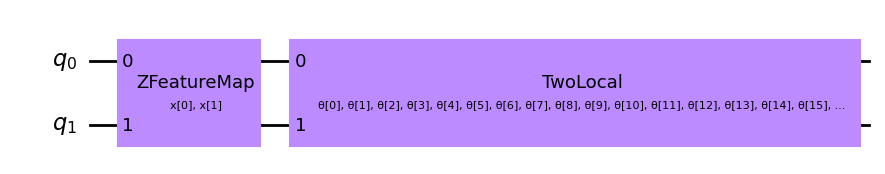

In [23]:
# construct feature map
feature_map = ZFeatureMap(n_of_features)

ansatz = TwoLocal(2, ['ry', 'rz'], 'cz', 'full', reps=4, insert_barriers=True)

# construct quantum circuit
qc = QuantumCircuit(n_of_features)
qc.append(feature_map, range(n_of_features))
qc.append(ansatz, range(n_of_features))
qc.decompose().draw(output="mpl")

In [24]:
from qiskit_machine_learning.neural_networks import SamplerQNN


def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2

sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [25]:
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30)
)

In [26]:
sampler_classifier.fit(X_train, y_train.to_numpy())
sampler_classifier.score(X_test, y_test)

0.7333333333333333

# Not Easy separable data

In [27]:
experiment_columns = ['petal_length', 'petal_width']
X_train_not_easy_separable, X_test_not_easy_separable, y_train_not_easy_separable, y_test_not_easy_separable, _, _ = get_dataset(
    50, 150, experiment_columns)

y_train_not_easy_separable[y_train_not_easy_separable == 2] = 0
y_test_not_easy_separable[y_test_not_easy_separable == 2] = 0

### Classical approach on not easy separable data

In [28]:
regressor = LogisticRegression()
regressor.fit(X_train_not_easy_separable, y_train_not_easy_separable)

regressor.score(X_test_not_easy_separable, y_test_not_easy_separable)

0.9666666666666667

## Quantum approach VQR

In [29]:
# construct feature map, ansatz, and optimizer

def create_vqc(in_feature_map, in_ansatz, optimizer: Union[Type[ADAM], Type[L_BFGS_B], Type[COBYLA]]):
    inner_vqc = VQC(
        feature_map=in_feature_map,
        ansatz=in_ansatz,
        loss="cross_entropy",
        optimizer=optimizer(maxiter=1000)
    )

    return inner_vqc

In [30]:
# ADAM

vqc = create_vqc(
    ZZFeatureMap(n_of_features),
    EfficientSU2(num_qubits=n_of_features, reps=2),
    optimizer=ADAM
)

vqc.fit(X_train_not_easy_separable, pd.get_dummies(y_train_not_easy_separable).to_numpy().astype(int))
vqc.score(X_test_not_easy_separable, pd.get_dummies(y_test_not_easy_separable).to_numpy().astype(int))

0.6666666666666666

In [31]:
# L_BFGS_B

vqc = create_vqc(
    ZZFeatureMap(n_of_features),
    EfficientSU2(num_qubits=n_of_features, reps=2),
    optimizer=L_BFGS_B
)

vqc.fit(X_train_not_easy_separable, pd.get_dummies(y_train_not_easy_separable).to_numpy().astype(int))
vqc.score(X_test_not_easy_separable, pd.get_dummies(y_test_not_easy_separable).to_numpy().astype(int))

0.8

In [32]:
# COBYLA

vqc = create_vqc(
    ZZFeatureMap(n_of_features),
    EfficientSU2(num_qubits=n_of_features, reps=2),
    optimizer=COBYLA
)

vqc.fit(X_train_not_easy_separable, pd.get_dummies(y_train_not_easy_separable).to_numpy().astype(int))
vqc.score(X_test_not_easy_separable, pd.get_dummies(y_test_not_easy_separable).to_numpy().astype(int))

0.6666666666666666

# EstimatorQNN ADAM

# different optimizers

In [36]:
estimator_classifier = get_estimator_qnn(COBYLA)

estimator_classifier.fit(X_train_not_easy_separable, y_train_not_easy_separable.to_numpy())
estimator_classifier.score(X_test_not_easy_separable, y_test_not_easy_separable)

0.43333333333333335

In [37]:
estimator_classifier_adam = get_estimator_qnn(ADAM)

estimator_classifier.fit(X_train_not_easy_separable, y_train_not_easy_separable.to_numpy())
estimator_classifier.score(X_test_not_easy_separable, y_test_not_easy_separable)

0.43333333333333335

In [39]:
estimator_classifier_l_bfgs_b = get_estimator_qnn(L_BFGS_B)

estimator_classifier.fit(X_train_not_easy_separable, y_train_not_easy_separable.to_numpy())
estimator_classifier.score(X_test_not_easy_separable, y_test_not_easy_separable)

0.43333333333333335